In [1]:
# Degradation Demo:
!pip install --target=$nb_path pzflow
!pip install git+https://github.com/LSSTDESC/RAIL.git#egg=rail[Full]
!git clone https://github.com/COINtoolbox/photoz_catalogues.git 

import matplotlib
matplotlib.use('Agg')
import pylab as pb
from pzflow.examples import example_flow
from rail.creation import Creator, engines
from rail.creation.degradation import InvRedshiftIncompleteness, LineConfusion
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpl_patches
import csv


  Cloning https://github.com/LSSTDESC/RAIL.git to /tmp/pip-install-zn9jdfeu/rail_19be808debaa472e9f8aa822125a6f5d
  Running command git clone -q https://github.com/LSSTDESC/RAIL.git /tmp/pip-install-zn9jdfeu/rail_19be808debaa472e9f8aa822125a6f5d
  Cloning https://github.com/LSSTDESC/DESC_BPZ to /tmp/pip-install-zn9jdfeu/desc-bpz_2a2fe0fd94c74cb5a69467b4e147a223
  Running command git clone -q https://github.com/LSSTDESC/DESC_BPZ /tmp/pip-install-zn9jdfeu/desc-bpz_2a2fe0fd94c74cb5a69467b4e147a223
fatal: destination path 'photoz_catalogues' already exists and is not an empty directory.
estimator randomPZ not installed
estimator trainZ not installed
estimator sklearn_nn not installed
estimator flexzboost not installed
estimator bpz_lite not installed


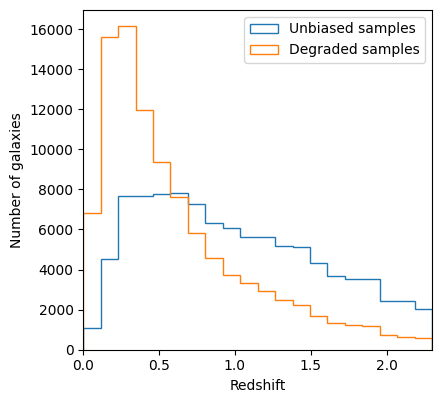

We rejected 7 columns in total


<Figure size 432x288 with 0 Axes>

In [3]:
flow = engines.FlowEngine(example_flow())
creator = Creator(flow)
degraded_creator = Creator(flow, degrader=InvRedshiftIncompleteness(0.1))

samples = creator.sample(100000)
degraded_samples = degraded_creator.sample(100000)

fig, ax = plt.subplots(figsize=(4.5,4.5), dpi=100)
ax.hist(samples['redshift'], bins=20, range=(0,2.3), histtype='step', label="Unbiased samples")
ax.hist(degraded_samples['redshift'], bins=20, range=(0,2.3), histtype='step', label="Degraded samples")
ax.legend()
ax.set(xlabel="Redshift", ylabel="Number of galaxies", xlim=(0,2.3))
plt.show()
pb.savefig("/content/drive/MyDrive/Coding/Results/InvRedshiftIncompleteness_degradation+photo-z+cde_metrics/z_pivot=0.1/z_pivot_0.1_degradation.pdf", dpi=300, bbox_inches = "tight")

np.savetxt('/content/drive/MyDrive/Coding/Data/InvRedshiftIncompleteness_degradation+photo-z+cde_metrics/z_pivot_0.1_samples.csv',samples, delimiter=',')
combined_pdfs=np.genfromtxt('/content/drive/MyDrive/Coding/Data/InvRedshiftIncompleteness_degradation+photo-z+cde_metrics/z_pivot_0.1_samples.csv', delimiter=',')

np.savetxt('/content/drive/MyDrive/Coding/Data/InvRedshiftIncompleteness_degradation+photo-z+cde_metrics/z_pivot_0.1_degraded_samples.csv',degraded_samples, delimiter=',')
combined_pdfs=np.genfromtxt('/content/drive/MyDrive/Coding/Data/InvRedshiftIncompleteness_degradation+photo-z+cde_metrics/z_pivot_0.1_degraded_samples.csv', delimiter=',')

degraded_samples.shape == samples.shape

# add error bars - srt of the total number in the bin


# Apply the Kolmogorov-Smirnov Test
from scipy import stats
p_value = 0.05
rejected = 0
for col in samples:
    test = stats.ks_2samp(samples[col], degraded_samples[col])
    if test[1] < p_value:
         rejected += 1
print("We rejected",rejected,"columns in total")


In [ ]:
# Degraded Samples Photo-z:

import matplotlib
matplotlib.use('Agg')
import sys
sys.path.append('/content/drive/MyDrive/Coding')
import GPz
from numpy import *
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import pylab as pb
from matplotlib.gridspec import GridSpec

########### Model options ###############

method = 'VC'               # select method, options = GL, VL, GD, VD, GC and VC [required]
                            #
m = 50                      # number of basis functions to use [required]
                            #
joint = True                # jointly learn a prior linear mean function [default=true]
                            #
heteroscedastic = True      # learn a heteroscedastic noise process, set to false interested only in point estimates
                            #
csl_method = 'normal'       # cost-sensitive learning option: [default='normal']
                            #       'balanced':     to weigh rare samples more heavly during train
                            #       'normalized':   assigns an error cost for each sample = 1/(z+1)
                            #       'normal':       no weights assigned, all samples are equally important
                            #
binWidth = 0.1              # the width of the bin for 'balanced' cost-sensitive learning [default=range(z_spec)/100]

decorrelate = True          # preprocess the data using PCA [default=False]

########### Training options ###########

dataPath_samples = '/content/drive/MyDrive/Coding/Data/InvRedshiftIncompleteness_degradation+photo-z+cde_metrics/z_pivot_0.1_samples.csv'    # path to the data set, has to be in the following format m_1,m_2,..,m_k,e_1,e_2,...,e_k,z_spec
                                        # where m_i is the i-th magnitude, e_i is its associated uncertainty and z_spec is the spectroscopic redshift
                                        # [required]
dataPath_degraded_samples = '/content/drive/MyDrive/Coding/Data/InvRedshiftIncompleteness_degradation+photo-z+cde_metrics/z_pivot_0.1_degraded_samples.csv'


maxIter = 500                   # maximum number of iterations [default=200]
maxAttempts = 50              # maximum iterations to attempt if there is no progress on the validation set [default=infinity]
trainSplit = 0.2               # percentage of data to use for training
validSplit = 0.2               # percentage of data to use for validation
testSplit  = 0.6               # percentage of data to use for testing

########### Start of script ###########

# Load samples
# read data from file
data = loadtxt(open(dataPath_samples,"rb"),delimiter=",")

X_samples = data[:, 1:6]
n,d = X_samples.shape
Y_samples = data[:, 0].reshape(n, 1)

filters = d/2

# log the uncertainties of the magnitudes, any additional preprocessing should be placed here
X_samples[:, int(filters):] = log(X_samples[:, int(filters):])



# Load degraded_samples
# read data from file
data_2 = loadtxt(open(dataPath_degraded_samples,"rb"),delimiter=",")

X_degraded_samples = data_2[:, 1:6]
n,d = X_degraded_samples.shape
Y_degraded_samples = data_2[:, 0].reshape(n, 1)

filters = d/2

# log the uncertainties of the magnitudes, any additional preprocessing should be placed here
X_degraded_samples[:, int(filters):] = log(X_degraded_samples[:, int(filters):])




# sample training, validation and testing sets from the data
training,validation,testing = GPz.sample(n,trainSplit,validSplit,testSplit)

# you can also select the size of each sample
# training,validation,testing = GPz.sample(n,10000,10000,10000)

# get the weights for cost-sensitive learning
omega = GPz.getOmega(Y_samples, method=csl_method)




# initialize the initial model
model_samples = GPz.GP(m,method=method,joint=joint,heteroscedastic=heteroscedastic,decorrelate=decorrelate)

# train the model
model_samples.train(X_samples.copy(), Y_samples.copy(), omega=omega, training=training, validation=validation, maxIter=maxIter, maxAttempts=maxAttempts)

########### NOTE ###########
# you can train the model gain, eve using different data, by executing:
# model.train(model,X,Y,options)

# use the model to generate predictions for the test set
mu_samples,sigma_samples,modelV_samples,noiseV_samples,_ = model_samples.predict(X_samples[testing,:].copy())




# initialize the initial model
model_degraded_samples = GPz.GP(m,method=method,joint=joint,heteroscedastic=heteroscedastic,decorrelate=decorrelate)

# train the model
model_degraded_samples.train(X_degraded_samples.copy(), Y_degraded_samples.copy(), omega=omega, training=training, validation=validation, maxIter=maxIter, maxAttempts=maxAttempts)

########### NOTE ###########
# you can train the model gain, eve using different data, by executing:
# model.train(model,X,Y,options)

# use the model to generate predictions for the test set
mu_degraded_samples,sigma_degraded_samples,modelV_degraded_samples,noiseV_degraded_samples,_ = model_degraded_samples.predict(X_samples[testing,:].copy())






########### Display Results ###########

# compute metrics   (compared to samples - true redshifts)
rmse_samples = sqrt(GPz.metrics(Y_samples[testing],mu_samples,sigma_samples,lambda y,mu,sigma: (y-mu)**2))
mll_samples  = GPz.metrics(Y_samples[testing],mu_samples,sigma_samples,lambda y,mu,sigma: -0.5*(y-mu)**2/sigma-0.5*log(sigma)-0.5*log(2*pi))
fr15_samples = GPz.metrics(Y_samples[testing],mu_samples,sigma_samples,lambda y,mu,sigma: 100.0*(abs(y-mu)/(y+1.0)<0.15))
fr05_samples = GPz.metrics(Y_samples[testing],mu_samples,sigma_samples,lambda y,mu,sigma: 100.0*(abs(y-mu)/(y+1.0)<0.05))
bias_samples = GPz.metrics(Y_samples[testing],mu_samples,sigma_samples,lambda y,mu,sigma: y-mu)



# compute metrics   (compared to samples - true redshifts)
rmse_degraded_samples = sqrt(GPz.metrics(Y_samples[testing],mu_degraded_samples,sigma_degraded_samples,lambda y,mu,sigma: (y-mu)**2))
mll_degraded_samples  = GPz.metrics(Y_samples[testing],mu_degraded_samples,sigma_degraded_samples,lambda y,mu,sigma: -0.5*(y-mu)**2/sigma-0.5*log(sigma)-0.5*log(2*pi))
fr15_degraded_samples = GPz.metrics(Y_samples[testing],mu_degraded_samples,sigma_degraded_samples,lambda y,mu,sigma: 100.0*(abs(y-mu)/(y+1.0)<0.15))
fr05_degraded_samples = GPz.metrics(Y_samples[testing],mu_degraded_samples,sigma_degraded_samples,lambda y,mu,sigma: 100.0*(abs(y-mu)/(y+1.0)<0.05))
bias_degraded_samples = GPz.metrics(Y_samples[testing],mu_degraded_samples,sigma_degraded_samples,lambda y,mu,sigma: y-mu)




# print metrics for the entire data
print(('{0:4s}\t\t\t{1:3s}\t\t\t{2:6s}\t\t\t{3:6s}\t\t\t{4:4s}'.format('RMSE', ' MLL', ' FR15', ' FR05', ' BIAS')))
print(('{0:1.7e}\t{1: 1.7e}\t{2: 1.7e}\t{3: 1.7e}\t{4: 1.7e}'.format(rmse_samples[-1], mll_samples[-1], fr15_samples[-1],fr05_samples[-1],bias_samples[-1])))
print(('{0:1.7e}\t{1: 1.7e}\t{2: 1.7e}\t{3: 1.7e}\t{4: 1.7e}'.format(rmse_degraded_samples[-1], mll_degraded_samples[-1], fr15_degraded_samples[-1],fr05_degraded_samples[-1],bias_degraded_samples[-1])))


Iter	 logML/n 		 Train RMSE		 Train RMSE/n		 Valid RMSE		 Valid MLL		 Time    
   1	-6.1441589e-01	 4.0570323e-01	-5.9637820e-01	 4.0702863e-01	[-6.0223835e-01]	 2.1137688e+00
   2	-4.9911218e-01	 3.5340658e-01	-4.5487831e-01	 3.5665306e-01	[-4.7011301e-01]	 1.8140485e+00
   3	-4.7712227e-01	 3.4237193e-01	-4.4024864e-01	 3.4666993e-01	[-4.6193769e-01]	 1.6654036e+00
   4	-4.7174873e-01	 3.4128243e-01	-4.3576062e-01	 3.4514288e-01	[-4.5541706e-01]	 1.7560375e+00
   5	-4.6277902e-01	 3.4060420e-01	-4.2741328e-01	 3.4501659e-01	[-4.4936234e-01]	 1.0926652e+00
   6	-4.4629744e-01	 3.3950359e-01	-4.1142926e-01	 3.4418022e-01	[-4.3383492e-01]	 1.1320398e+00
   7	-4.1961803e-01	 3.3866274e-01	-3.8863459e-01	 3.4347224e-01	[-4.1037761e-01]	 1.0546947e+00
   8	-3.9835043e-01	 3.4220314e-01	-3.7739871e-01	 3.4655548e-01	[-3.9514883e-01]	 1.0824740e+00
   9	-3.6819380e-01	 3.4015770e-01	-3.5352915e-01	 3.4446321e-01	[-3.6951093e-01]	 1.0685723e+00
  10	-3.4126056e-01	 3.3778045e-01	-3.3260494e-0

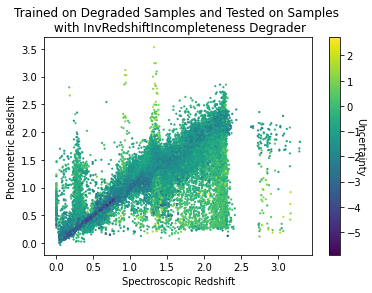

In [36]:
# plot scatter plots for density and uncertainty
f = plt.figure(1)
plt.scatter(Y_samples[testing,:],mu_samples,s=5, c=np.log10(squeeze(sigma_samples)), edgecolor=['none'])
plt.scatter(Y_samples[testing,:],mu_degraded_samples,s=5, c=np.log10(squeeze(sigma_degraded_samples)), edgecolor=['none'])
cbar = plt.colorbar()
cbar.set_label('Uncertainty', rotation=270, labelpad=10)
plt.xlabel('Spectroscopic Redshift')
plt.ylabel('Photometric Redshift')
plt.title('Trained on Degraded Samples and Tested on Samples \n with InvRedshiftIncompleteness Degrader')
pb.savefig("/content/drive/MyDrive/Coding/Results/InvRedshiftIncompleteness_degradation+photo-z+cde_metrics/z_pivot=0.1/z_pivot_0.1_photoz_1.pdf", dpi=300, bbox_inches = "tight")

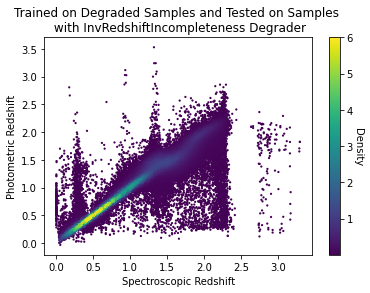

In [37]:
f = plt.figure(2)
xy_s = hstack([Y_samples[testing,:],mu_samples]).T
xy_ds = hstack([Y_samples[testing,:],mu_degraded_samples]).T

z_s = gaussian_kde(xy_s)(xy_s)
z_ds = gaussian_kde(xy_ds)(xy_ds)
plt.scatter(Y_samples[testing,:],mu_samples,s=5, c=z_s, edgecolor=['none'])
plt.scatter(Y_samples[testing,:],mu_degraded_samples,s=5, c=z_ds, edgecolor=['none'])
cbar = plt.colorbar()
cbar.set_label('Density', rotation=270, labelpad=10)
plt.xlabel('Spectroscopic Redshift')
plt.ylabel('Photometric Redshift')
plt.title('Trained on Degraded Samples and Tested on Samples \n with InvRedshiftIncompleteness Degrader')
pb.savefig("/content/drive/MyDrive/Coding/Results/InvRedshiftIncompleteness_degradation+photo-z+cde_metrics/z_pivot=0.1/z_pivot_0.1_photoz_2.pdf", dpi=300, bbox_inches = "tight")

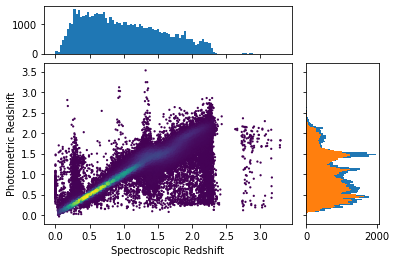

In [38]:
# marginal histograms of spectroscopic redshifts and photometric redshift estimates
f = plt.figure(2.1)

gs = GridSpec(4,4)

ax_joint = f.add_subplot(gs[1:4,0:3])
ax_marg_x = f.add_subplot(gs[0,0:3])
ax_marg_y = f.add_subplot(gs[1:4,3])

xy_s = hstack([Y_samples[testing,:],mu_samples]).T
xy_ds = hstack([Y_samples[testing,:],mu_degraded_samples]).T
z_s = gaussian_kde(xy_s)(xy_s)
z_ds = gaussian_kde(xy_ds)(xy_ds)

#ax_joint.scatter(Y_samples[testing,:], mu_samples, s=5, c=z, edgecolor=['none'])
im = ax_joint.scatter(Y_samples[testing,:], mu_samples, s=5, c=z_s, cmap=plt.cm.viridis, edgecolor=['none'])
im = ax_joint.scatter(Y_samples[testing,:], mu_degraded_samples, s=5, c=z_ds, cmap=plt.cm.viridis, edgecolor=['none'])
#f.colorbar(im, ax=ax_joint)

ax_marg_x.hist(Y_samples[testing,:], bins=100)
ax_marg_y.hist(mu_samples,orientation="horizontal", bins=100)
ax_marg_y.hist(mu_degraded_samples,orientation="horizontal", bins=100)

# Turn off tick labels on marginals
plt.setp(ax_marg_x.get_xticklabels(), visible=False)
plt.setp(ax_marg_y.get_yticklabels(), visible=False)

# Set labels on joint
ax_joint.set_xlabel('Spectroscopic Redshift')
ax_joint.set_ylabel('Photometric Redshift')

# Set labels on marginals
#ax_marg_y.set_xlabel('Marginal x label')
#ax_marg_x.set_ylabel('Marginal y label')

#ax_joint.set_title('2 iterations - Trained on Samples and Tested on Samples', loc='center')

pb.savefig("/content/drive/MyDrive/Coding/Results/InvRedshiftIncompleteness_degradation+photo-z+cde_metrics/z_pivot=0.1/z_pivot_0.1_photoz_2.1.pdf", dpi=300, bbox_inches = "tight")
#pb.savefig("/content/drive/MyDrive/Coding/Results/InvRedshiftIncompleteness_degradation+photo-z+cde_metrics/z_pivot=0.1/z_pivot_0.1_photoz_2.2.pdf", dpi=300, bbox_inches = "tight")

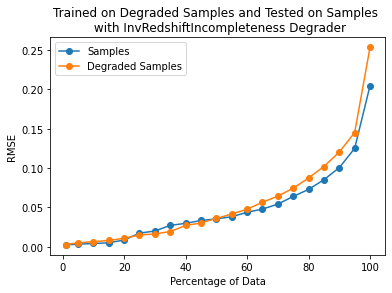

In [39]:
# plot the change in metrics as functions of data percentage
x = array(list(range(0,20+1)))*5
x[0]=1

ind_s = x*len(rmse_samples) // 100
ind_ds = x*len(rmse_degraded_samples) // 100

f = plt.figure(3)
plt.plot(x,rmse_samples[ind_s-1],'o-', label="Samples")
plt.plot(x,rmse_degraded_samples[ind_ds-1],'o-', label="Degraded Samples")
plt.legend()
plt.xlabel('Percentage of Data')
plt.ylabel('RMSE')
plt.title('Trained on Degraded Samples and Tested on Samples \n with InvRedshiftIncompleteness Degrader')
pb.savefig("/content/drive/MyDrive/Coding/Results/InvRedshiftIncompleteness_degradation+photo-z+cde_metrics/z_pivot=0.1/z_pivot_0.1_rmse.pdf", dpi=300, bbox_inches = "tight")

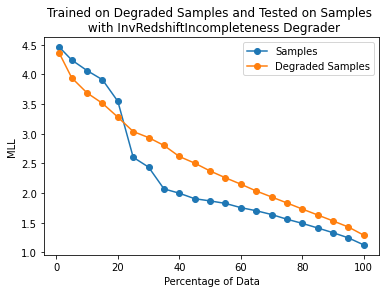

In [40]:
f = plt.figure(4)
plt.plot(x,mll_samples[ind_s-1],'o-', label="Samples")
plt.plot(x,mll_degraded_samples[ind_ds-1],'o-',  label="Degraded Samples")
plt.legend(loc='upper right')
plt.xlabel('Percentage of Data')
plt.ylabel('MLL')
plt.title('Trained on Degraded Samples and Tested on Samples \n with InvRedshiftIncompleteness Degrader')
pb.savefig("/content/drive/MyDrive/Coding/Results/InvRedshiftIncompleteness_degradation+photo-z+cde_metrics/z_pivot=0.1/z_pivot_0.1_photoz_4_mll.pdf", dpi=300, bbox_inches = "tight")

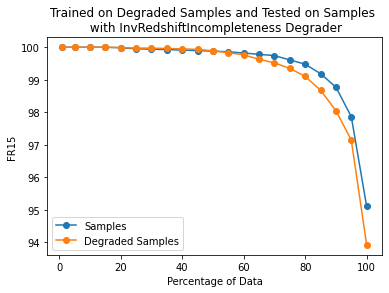

In [41]:
f = plt.figure(5)
plt.plot(x,fr15_samples[ind_s-1],'o-', label="Samples")
plt.plot(x,fr15_degraded_samples[ind_ds-1],'o-', label="Degraded Samples")
plt.legend()
plt.xlabel('Percentage of Data')
plt.ylabel('FR15')
plt.title('Trained on Degraded Samples and Tested on Samples \n with InvRedshiftIncompleteness Degrader')
pb.savefig("/content/drive/MyDrive/Coding/Results/InvRedshiftIncompleteness_degradation+photo-z+cde_metrics/z_pivot=0.1/z_pivot_0.1_photoz_5_fr15.pdf", dpi=300, bbox_inches = "tight")

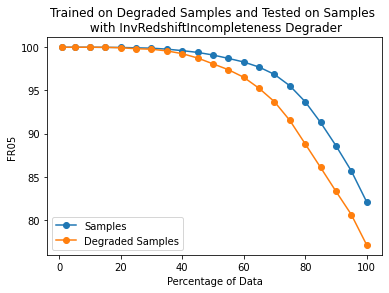

In [42]:
f = plt.figure(6)
plt.plot(x,fr05_samples[ind_s-1],'o-', label="Samples")
plt.plot(x,fr05_degraded_samples[ind_ds-1],'o-',  label="Degraded Samples")
plt.legend()
plt.xlabel('Percentage of Data')
plt.ylabel('FR05')
plt.title('Trained on Degraded Samples and Tested on Samples \n with InvRedshiftIncompleteness Degrader')
pb.savefig("/content/drive/MyDrive/Coding/Results/InvRedshiftIncompleteness_degradation+photo-z+cde_metrics/z_pivot=0.1/z_pivot_0.1_photoz_6_fr05.pdf", dpi=300, bbox_inches = "tight")

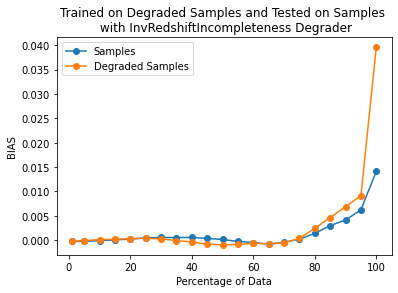

In [43]:
f = plt.figure(7)
plt.plot(x,bias_samples[ind_s-1],'o-', label="Samples")
plt.plot(x,bias_degraded_samples[ind_ds-1],'o-', label="Degraded Samples")
plt.legend()
plt.xlabel('Percentage of Data')
plt.ylabel('BIAS')
plt.title('Trained on Degraded Samples and Tested on Samples \n with InvRedshiftIncompleteness Degrader')
pb.savefig("/content/drive/MyDrive/Coding/Results/InvRedshiftIncompleteness_degradation+photo-z+cde_metrics/z_pivot=0.1/z_pivot_0.1_photoz_7_bias.pdf", dpi=300, bbox_inches = "tight")


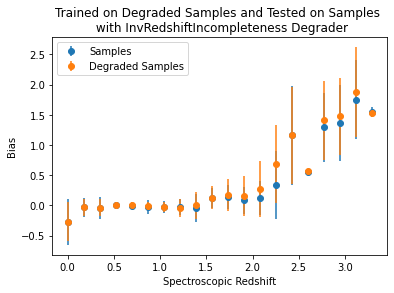

In [44]:
# plot mean and standard deviation of different scores as functions of spectroscopic redshift using 20 bins
f = plt.figure(8)
centers_s,means_s,stds_s = GPz.bin(Y_samples[testing],Y_samples[testing]-mu_samples,20)
centers_ds,means_ds,stds_ds = GPz.bin(Y_samples[testing],Y_samples[testing]-mu_degraded_samples,20)
plt.errorbar(centers_s,means_s,stds_s,fmt='o', label= 'Samples')
plt.errorbar(centers_ds,means_ds,stds_ds,fmt='o', label= 'Degraded Samples')
plt.legend(loc='upper left')
plt.xlabel('Spectroscopic Redshift')
plt.ylabel('Bias')
plt.title('Trained on Degraded Samples and Tested on Samples \n with InvRedshiftIncompleteness Degrader')
pb.savefig("/content/drive/MyDrive/Coding/Results/InvRedshiftIncompleteness_degradation+photo-z+cde_metrics/z_pivot=0.1/z_pivot_0.1_photoz_8_bias.pdf", dpi=300, bbox_inches = "tight")

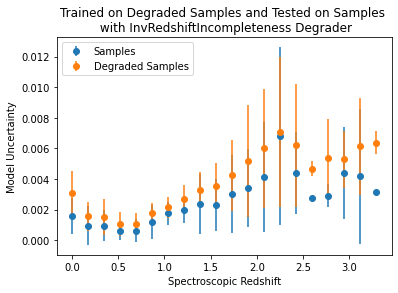

In [45]:
f = plt.figure(9)
centers_s,means_s,stds_s = GPz.bin(Y_samples[testing],sqrt(modelV_samples),20)
centers_ds,means_ds,stds_ds = GPz.bin(Y_samples[testing],sqrt(modelV_degraded_samples),20)
plt.errorbar(centers_s,means_s,stds_s,fmt='o', label= 'Samples')
plt.errorbar(centers_ds,means_ds,stds_ds,fmt='o', label= 'Degraded Samples')
plt.legend(loc='upper left')
plt.xlabel('Spectroscopic Redshift')
plt.ylabel('Model Uncertainty')
plt.title('Trained on Degraded Samples and Tested on Samples \n with InvRedshiftIncompleteness Degrader')
pb.savefig("/content/drive/MyDrive/Coding/Results/InvRedshiftIncompleteness_degradation+photo-z+cde_metrics/z_pivot=0.1/z_pivot_0.1_photoz_9_modelV.pdf", dpi=300, bbox_inches = "tight")

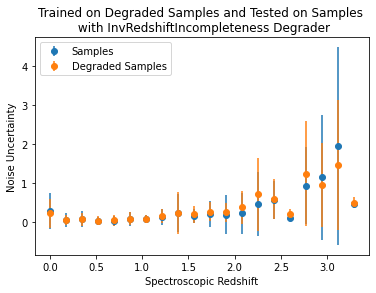

In [46]:
f = plt.figure(10)
centers_s,means_s,stds_s = GPz.bin(Y_samples[testing],sqrt(noiseV_samples),20)
centers_ds,means_ds,stds_ds = GPz.bin(Y_samples[testing],sqrt(noiseV_degraded_samples),20)
plt.errorbar(centers_s,means_s,stds_s,fmt='o', label= 'Samples')
plt.errorbar(centers_ds,means_ds,stds_ds,fmt='o', label= 'Degraded Samples')
plt.legend(loc='upper left')
plt.xlabel('Spectroscopic Redshift')
plt.ylabel('Noise Uncertainty')
plt.title('Trained on Degraded Samples and Tested on Samples \n with InvRedshiftIncompleteness Degrader')
pb.savefig("/content/drive/MyDrive/Coding/Results/InvRedshiftIncompleteness_degradation+photo-z+cde_metrics/z_pivot=0.1/z_pivot_0.1_photoz_10_noiseV.pdf", dpi=300, bbox_inches = "tight")

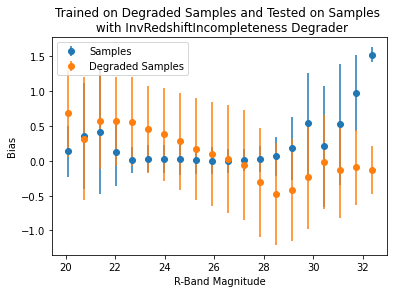

In [47]:
# plot of bias as a function of magnitude 
f = plt.figure(11)
X_s = data[:, 2].reshape(n,1)
centers_s,means_s,stds_s = GPz.bin(X_s[testing,:], Y_samples[testing,:] - mu_samples, 20)
centers_ds,means_ds,stds_ds = GPz.bin(X_s[testing,:], Y_degraded_samples[testing,:] - mu_degraded_samples, 20)
plt.errorbar(centers_s,means_s,stds_s,fmt='o', label= 'Samples')
plt.errorbar(centers_ds,means_ds,stds_ds,fmt='o', label= 'Degraded Samples')
plt.legend()
plt.xlabel('R-Band Magnitude')
plt.ylabel('Bias')
plt.title('Trained on Degraded Samples and Tested on Samples \n with InvRedshiftIncompleteness Degrader')
pb.savefig("/content/drive/MyDrive/Coding/Results/InvRedshiftIncompleteness_degradation+photo-z+cde_metrics/z_pivot=0.1/z_pivot_0.1_photoz_11.pdf", dpi=300, bbox_inches = "tight")

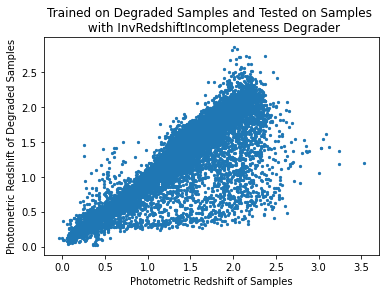

In [48]:
f = plt.figure(12)
plt.scatter(mu_samples, mu_degraded_samples, s=5)
plt.xlabel('Photometric Redshift of Samples')
plt.ylabel('Photometric Redshift of Degraded Samples')
plt.title('Trained on Degraded Samples and Tested on Samples \n with InvRedshiftIncompleteness Degrader')
pb.savefig("/content/drive/MyDrive/Coding/Results/InvRedshiftIncompleteness_degradation+photo-z+cde_metrics/z_pivot=0.1/z_pivot_0.1_photoz_12.pdf", dpi=300, bbox_inches = "tight")

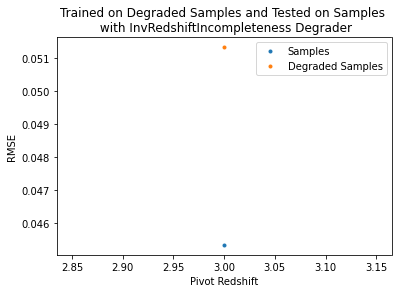

In [49]:
import numpy as np

z_pivot = 3 

avg_rmse_samples = sum(rmse_samples) / len(rmse_samples)
avg_rmse_degraded_samples = sum(rmse_degraded_samples) / len(rmse_degraded_samples)

f = plt.figure(13)
plt.plot(z_pivot, avg_rmse_samples,'.', label="Samples")
plt.plot(z_pivot, avg_rmse_degraded_samples,'.', label="Degraded Samples")

plt.legend()
plt.xlabel('Pivot Redshift')
plt.ylabel('RMSE')
plt.title('Trained on Degraded Samples and Tested on Samples \n with InvRedshiftIncompleteness Degrader')
pb.savefig("/content/drive/MyDrive/Coding/Results/InvRedshiftIncompleteness_degradation+photo-z+cde_metrics/z_pivot=0.1/z_pivot_0.1_photoz_13_aver_rmse_vs_z_pivot.pdf", dpi=300, bbox_inches = "tight")

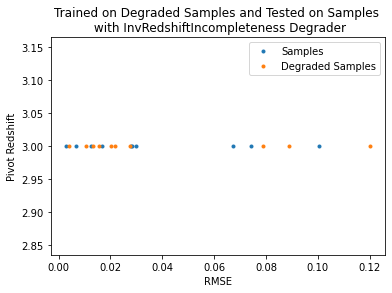

In [51]:
import numpy as np

idx = np.random.choice(np.arange(len(rmse_samples)), 10, replace=False)
rmse_samples_10 = rmse_samples[idx]
rmse_degraded_samples_10 = rmse_degraded_samples[idx]

z_pivot_no = 3
z_pivot = np.tile(z_pivot_no, 10)

f = plt.figure(14)
plt.plot(rmse_samples_10, z_pivot,'.', label="Samples")
plt.plot(rmse_degraded_samples_10,z_pivot, '.', label="Degraded Samples")
plt.legend()
plt.xlabel('RMSE')
plt.ylabel('Pivot Redshift')
plt.title('Trained on Degraded Samples and Tested on Samples \n with InvRedshiftIncompleteness Degrader')
pb.savefig("/content/drive/MyDrive/Coding/Results/InvRedshiftIncompleteness_degradation+photo-z+cde_metrics/z_pivot=0.1/z_pivot_0.1_photoz_14_rmse_vs_z_pivot.pdf", dpi=300, bbox_inches = "tight")

In [52]:
# save output as a comma seperated values (mean,sigma,model_variance,noise_variance)
savetxt(method+'_'+str(m)+'_'+csl_method+'.csv', array([mu_samples,sigma_samples,modelV_samples,noiseV_samples])[:,:,0].T, delimiter=',')

savetxt(method+'_'+str(m)+'_'+csl_method+'.csv', array([mu_degraded_samples,sigma_degraded_samples,modelV_degraded_samples,noiseV_degraded_samples])[:,:,0].T, delimiter=',')

In [53]:
# CDETOOLS METRICS CODE

!pip install cde-diagnostics
!pip install cdetools
!pip install corner
!pip install FlexCode
!pip install pzflow
!pip install sklearn
!pip install xgboost==0.90


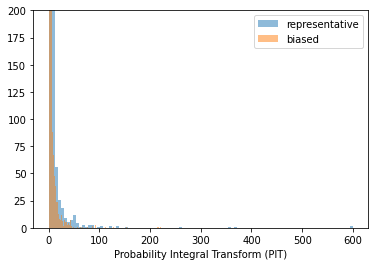

In [54]:
from cdetools import cde_loss, cdf_coverage, hpd_coverage
from scipy.stats import norm
import numpy as np

n_galaxies = 100000   # from the size of samples
n_grid = 200
z_max = 2
z_min = 0

y_grid = np.arange(z_min, z_max, 0.01)
y_grid_bias = np.arange(z_min, z_max, 0.01)

#Creating a Normal Distribution
def normal_dist(y_grid , mu_samples , sigma_samples):
    prob_density = 1/((2*np.pi*sigma_samples**2)**(1/2)) * np.exp(-0.5*((y_grid-mu_samples)/sigma_samples)**2)
    return prob_density

cde_test = normal_dist(y_grid,mu_samples,sigma_samples)

cde_test_bias = normal_dist(y_grid_bias, mu_degraded_samples, sigma_degraded_samples)


pit_values = cdf_coverage.cdf_coverage(cde_test, y_grid, Y_samples[testing])
pit_values_bias = cdf_coverage.cdf_coverage(cde_test_bias, y_grid_bias, Y_samples[testing])

plt.hist(pit_values, alpha=0.5, bins=100, label='representative')
plt.hist(pit_values_bias, alpha=0.5, bins=100, label='biased')
plt.ylim(0, 200)
plt.legend()
plt.xlabel('Probability Integral Transform (PIT)')
pb.savefig("/content/drive/MyDrive/Coding/Results/InvRedshiftIncompleteness_degradation+photo-z+cde_metrics/z_pivot=0.1/z_pivot_0.1_cde_PIT.pdf", dpi=300, bbox_inches = "tight")


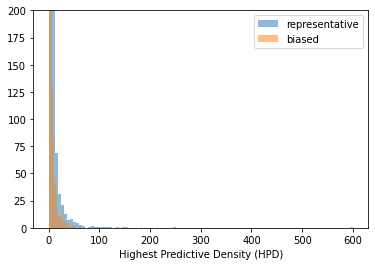

In [55]:
hpd_cov = hpd_coverage.hpd_coverage(cde_test, y_grid, Y_samples[testing])
hpd_cov_bias = hpd_coverage.hpd_coverage(cde_test_bias, y_grid_bias, Y_samples[testing])

plt.hist(hpd_cov, alpha=0.5, bins=100, label='representative')
plt.hist(hpd_cov_bias, alpha=0.5, bins=100, label='biased')
plt.ylim(0,200)
plt.legend()
plt.xlabel('Highest Predictive Density (HPD)')
pb.savefig("/content/drive/MyDrive/Coding/Results/InvRedshiftIncompleteness_degradation+photo-z+cde_metrics/z_pivot=0.1/z_pivot_0.1_cde_HPD.pdf", dpi=300, bbox_inches = "tight")

In [56]:
print(cde_loss.cde_loss(cde_test, y_grid, Y_samples[testing]))
print(cde_loss.cde_loss(cde_test_bias, y_grid_bias, Y_samples[testing]))

(4797.642506974403, 1367.7005798815173)
(1322.5771105216763, 211.94846971457525)
